Simple non linear regression with pytorch

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [2]:
n_samples = 500
x_data = np.random.randn(n_samples, 1).flatten()
eps = np.random.normal(0.0, 1.0, n_samples)
# y_data = 3.*np.sin(2.*x_data) + eps
y_data = 2.*x_data**2 + eps
data = pd.DataFrame({"x_data": x_data,
                     "y_data": y_data})

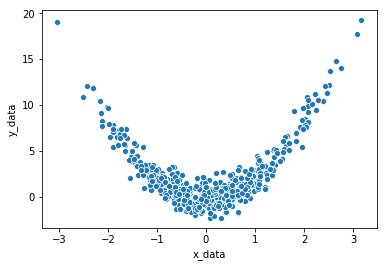

In [3]:
sns.scatterplot(x="x_data",
                y="y_data",
                data = data)

# DATALOADER

In [4]:
from torch.utils.data import Dataset, DataLoader

class NLRDataset(Dataset):
    def __init__(self, x, y):
        super(NLRDataset, self).__init__()
        
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x_data = self.x
        y_data = self.y
        return x_data[idx], y_data[idx]

In [5]:
def make_dataset(x_data, y_data, num_samples):
    train_num = int(0.8 * num_samples)
    train_x, test_x = x_data[:train_num], x_data[train_num:]
    train_y, test_y = y_data[:train_num], y_data[train_num:]
    train_dataset = NLRDataset(train_x, train_y)
    test_dataset = NLRDataset(test_x, test_y)
    partition_dictionary = {"train_set": train_dataset,
                            "test_set": test_dataset}
    
    return partition_dictionary

In [6]:
partition_dictionary = make_dataset(x_data, y_data, 500)
partition_dictionary

{'train_set': <__main__.NLRDataset at 0x21abce95550>,
 'test_set': <__main__.NLRDataset at 0x21abce95748>}

# MODEL

In [7]:
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_dtype(torch.double)

class NLR(nn.Module):
    def __init__(self, hidden_size, activation=None):
        super(NLR, self).__init__()
        
        self.hidden_size = hidden_size
        self.fc = nn.Linear(1, self.hidden_size)
        self.predictor = nn.Linear(self.hidden_size, 1)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        x = self.predictor(x)
        
        return x

# EXPERIMENT

In [8]:
def train(model, criteria, optimizer, batch_size, dataset):
    train_loss = 0.0
    model.train()
    for i, batch in enumerate(dataset):
        x_batch = (batch[0].clone().detach().requires_grad_(True)).view(-1, 1)
        y_batch = (batch[1].clone().detach().requires_grad_(True)).view(-1, 1)
        optimizer.zero_grad()

        y_pred = model(x_batch)
        y_pred.require_grad = False
        loss = criteria(y_pred, y_batch)
        train_loss += loss.item()/len(dataset)
        loss.backward()
        optimizer.step()
        
    return model, train_loss

In [9]:
def test(model, criteria, batch_size, dataset):
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataset):
            x_batch = (batch[0].clone().detach().requires_grad_(True)).view(-1, 1)
            y_batch = (batch[1].clone().detach().requires_grad_(True)).view(-1, 1)
            y_pred = model(x_batch)
            
            loss = criteria(y_pred, y_batch)
            test_loss += loss.item()/len(dataset)
        
    return test_loss

In [10]:
def experiment(num_epoch, batch_size, data, hidden_size, activation):
    if activation == "relu":
        activation = nn.ReLU()
        
    model = NLR(hidden_size, activation)
    optimizer = torch.optim.Adam(model.parameters())
    criteria = nn.MSELoss()
    
    train_dataset = DataLoader(dataset = data["train_set"],
                               batch_size = batch_size,
                               shuffle = True)
    test_dataset = DataLoader(dataset = data["test_set"],
                              batch_size = batch_size,
                              shuffle = True)
    
    train_loss_list = []
    test_loss_list = []
    epoch_list = []
    for epoch in range(num_epoch):
        model, train_loss = train(model, criteria, optimizer, batch_size, train_dataset)
        test_loss = test(model, criteria, batch_size, test_dataset)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        epoch_list.append(epoch)
        
    ret_DF = pd.DataFrame({"epoch": epoch_list * 2,
                           "loss type": ["train" for i in range(len(train_loss_list))] + ["test" for i in range(len(test_loss_list))],
                           "loss value": train_loss_list + test_loss_list})
    
    return model, ret_DF

In [11]:
trained_model, DF = experiment(100, 20, partition_dictionary, 200, "relu")

In [12]:
print(DF)

     epoch loss type  loss value
0        0     train   10.160244
1        1     train    6.852901
2        2     train    5.349728
3        3     train    4.504523
4        4     train    3.851815
5        5     train    3.250373
6        6     train    2.774526
7        7     train    2.362749
8        8     train    2.042924
9        9     train    1.801433
10      10     train    1.624245
11      11     train    1.508455
12      12     train    1.412496
13      13     train    1.358115
14      14     train    1.310155
15      15     train    1.293392
16      16     train    1.268574
17      17     train    1.253992
18      18     train    1.243519
19      19     train    1.232409
20      20     train    1.220328
21      21     train    1.209244
22      22     train    1.206503
23      23     train    1.196820
24      24     train    1.187053
25      25     train    1.180157
26      26     train    1.169993
27      27     train    1.163090
28      28     train    1.158607
29      29

# VISUALIZAITON

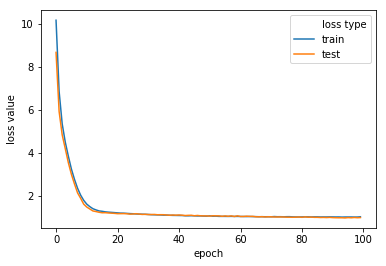

In [13]:
g = sns.lineplot(x="epoch", y="loss value", hue="loss type", data=DF)

# TEST

In [14]:
x_test = np.arange(-5., 5., 0.2).flatten()
y_true = 2.*x_test**2
num_test_batches = x_test.shape[0] // 10
y_test = []
for i in range(num_test_batches):
    x_batch = x_test[i*10:(i+1)*10]
    y_test_batch = []
    for j in range(len(x_batch)):
        y_test_batch.append(trained_model(torch.tensor(x_batch[j]).view(-1)).item())
    y_test.append(y_test_batch)
y_test = np.asarray(y_test).flatten()

data = pd.DataFrame({"x": np.concatenate((x_test, x_test)),
                     "y": np.concatenate((y_true,y_test)),
                     "type": np.asarray(["true" for i in range(len(y_true))] + ["pred" for i in range(len(y_test))])})

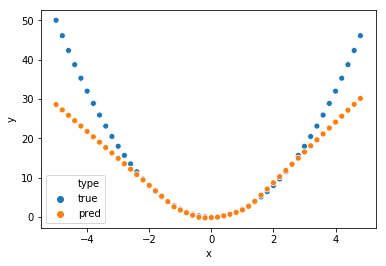

In [15]:
sns.scatterplot(x="x",
                y="y",
                hue="type",
                data=data)